In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-tweets-sentiment-dataset/Tweets.csv


**Problem Statement**

In the age of social media, understanding public sentiment is crucial for businesses, policymakers, and researchers. Twitter, being one of the most popular social media platforms, generates a vast amount of textual data daily. This notebook aims to analyze the sentiment expressed in Twitter tweets. By leveraging natural language processing (NLP) and machine learning techniques, I seek to classify tweets into different sentiment categories, thereby providing insights into public opinion on various topics.

**Goals**

The primary goal of this notebook is to develop a machine learning model for sentiment analysis of Twitter tweets. Initially, I will conduct data exploration and cleaning to understand the distribution of sentiments in the dataset and prepare the tweet texts for analysis. This will involve cleaning and preprocessing the text data. Next, I will focus on feature engineering by transforming the textual data into numerical representations using techniques like TF-IDF or word embeddings.

Following this, I will build and train various machine learning models to classify the sentiments of tweets, compare the performance of different models and select the best-performing one. The evaluation phase will involve assessing the models using appropriate metrics such as accuracy, precision, recall, and F1 score to understand their strengths and weaknesses.

Finally, I will summarize the findings, providing insights into the sentiment trends observed in the dataset. I will also discuss the potential applications of the sentiment analysis model and suggest areas for future work. The ultimate objective is to enable more effective decision-making and strategy development based on the analysis of public sentiment expressed in tweets.

**Selected Machine Learning Models**

For this sentiment analysis notebook, I will utilize BERT (Bidirectional Encoder Representations from Transformers), Logistic Regression, and LSTM (Long Short-Term Memory) using PyTorch. BERT is a state-of-the-art transformer model pre-trained on a large corpus of text. It excels at capturing the context and nuances of language, making it highly effective for text classification tasks such as sentiment analysis. By fine-tuning BERT for sentiment analysis, I can achieve high performance due to its deep understanding of linguistic patterns.

Logistic Regression, on the other hand, is a simple and interpretable model that serves well as a baseline for text classification. It allows me to establish a reference point for performance, making it easier to understand the gains achieved by more complex models like BERT. Its simplicity and effectiveness in many text classification tasks make it a reliable choice for initial experimentation and comparison.

Long Short-Term Memory (LSTM), a type of recurrent neural network (RNN), is specifically designed for sequential data like text. It captures long-term dependencies and patterns within the text, making it particularly suitable for tasks that require understanding the sequential nature of language. Using PyTorch, I can build and train an LSTM model to classify the sentiment of tweets effectively. This model is widely used in NLP tasks due to its ability to handle varying sequence lengths and retain important information over long text sequences.

Together, these models provide a comprehensive approach to sentiment analysis. BERT offers cutting-edge performance with its deep contextual understanding, Logistic Regression provides a solid baseline with interpretability, and LSTM captures the sequential dependencies in text data. These selections allow me to explore different methodologies and compare their effectiveness in sentiment analysis, providing a well-rounded analysis of the task at hand.

In [39]:
# Install all necessary libraries and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing and text handling
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from collections import Counter

# Machine learning models
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Deep Learning libraries (PyTorch)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler

# Transformers for BERT
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from datasets import Dataset

# Word Embeddings
import gensim

# NLTK resources
nltk.download('stopwords')
nltk.download('punkt')

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Visualization Settings
sns.set(style='whitegrid')

# Setting device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
# Load in the dataset
df= pd.read_csv('/kaggle/input/twitter-tweets-sentiment-dataset/Tweets.csv')

In [6]:
# View the data
print(df.head())

       textID                                               text  \
0  cb774db0d1                I`d have responded, if I were going   
1  549e992a42      Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                          my boss is bullying me...   
3  9642c003ef                     what interview! leave me alone   
4  358bd9e861   Sons of ****, why couldn`t they put them on t...   

                         selected_text sentiment  
0  I`d have responded, if I were going   neutral  
1                             Sooo SAD  negative  
2                          bullying me  negative  
3                       leave me alone  negative  
4                        Sons of ****,  negative  


In [7]:
# Check the shape
print(df.shape)

(27481, 4)


In [8]:
# Explore the data types
print(df.dtypes)

textID           object
text             object
selected_text    object
sentiment        object
dtype: object


In [9]:
# Check for missing values and drop them
print(df.isnull().sum())
df = df.dropna()
print(df.isnull().sum())

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64
textID           0
text             0
selected_text    0
sentiment        0
dtype: int64


**Cleaning and Preprocessing the Text Data**

Text data often contains various elements that are not useful for analysis. In the next code block, I will create a function to clean and preprocess the text which will include the following techniques:

* Removing HTML tags, URLs, mentions and other unwanted elements
* Converting text to lowercase, which helps to ensure consistent tokenization and feature representation
* Tokenize the text into words, which is the process of splitting the text into individual words or tokens
* Remove stopwords. Stopwords are common words that don't really carry any meaning such as "the", "is" and "a" for example.
* Perform Stemming, which is a technique used to reduce words to their root form.

Let's proceed.

In [11]:
# Define a function to clean and preprocess the text
def preprocess_text(text):
    # Remove HTML tags and URLs
    text = re.sub(r'<.*?>|http\S+', '', text)
    # Convert text to lower case
    text = text.lower()
    # Tokenize the text
    tokens = word_tokenize(text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    # Perform stemming
    stemmer = PorterStemmer()
    tokens = [stemmer.stem(word) for word in tokens]
    # Join the tokens back into a single string
    cleaned_text = ' '.join(tokens)
    return cleaned_text

# Apply preprocessing function to text column
df['cleaned_text'] = df['text'].apply(preprocess_text)

**Feature Engineering**

Now, I will proceed to perform feature engineering, which is the process of transforming raw data into features that can be used by machine learning models for training and prediction. In the case of text data, I need to transform the text into a numerical format that can be understood by the models. In this notebook, I will explore two common approaches: TF-IDF Vectorization and Word Embeddings.

**TF-IDF Vectorization**

TF-IDF (Term Frequency-Inverse Document Frequency) is a technique that represents text data as a vector of term weights. It considers both the frequency of a term in a document and the inverse frequency of the term across the entire corpus. This helps to capture the importance of each term in the context of the specific document and the overall corpus.

**Word Embeddings**

Word Embeddings are dense vectorization of words, where words with similar meanings are mapped to similar vectors in the embedding space. These embeddings capture semantic and contextual information, making them useful for various NLP tasks, including sentiment analysis. One very popular method for obtaining word embeddings is Word2Vec, which is what I will be using.

In [15]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectors = tfidf_vectorizer.fit_transform(df['cleaned_text'])

# Word Embeddings using Word2Vec
tokenized_texts = [text.split() for text in df['cleaned_text']]
word2vec_model = gensim.models.Word2Vec(tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)

**Model Building and Training**

Now that the text data is represented as numerical features (TF-IDF vectors and word embeddings), I can start building and training the machine learning models for sentiment analysis. I will begin with Logistic Regression. Then, I will proceed with the BERT (Bidirectional Encoder Representations from Transformers) model. And finally, I will build the LSTM (Long Short-Term Memory) Neural Network.

In [16]:
# Split the data into training and test sets for the Logistic Regression model
X_train, X_test, y_train, y_test = train_test_split(tfidf_vectors, df['sentiment'], test_size=0.2, random_state=42)

In [17]:
# Train and fit the Logistic Regression model
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

LogisticRegression()

In [18]:
# Predict on the test set
y_pred = lr_model.predict(X_test)

In [19]:
# Calculate evaluation metrics for Logistic Regression
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'Logistic Regression - Accuracy: {accuracy:.2f}')
print(f'Logistic Regression - Precision: {precision:.2f}')
print(f'Logistic Regression - Recall: {recall:.2f}')
print(f'Logistic Regression - F1 Score: {f1:.2f}')

Logistic Regression - Accuracy: 0.68
Logistic Regression - Precision: 0.69
Logistic Regression - Recall: 0.68
Logistic Regression - F1 Score: 0.68


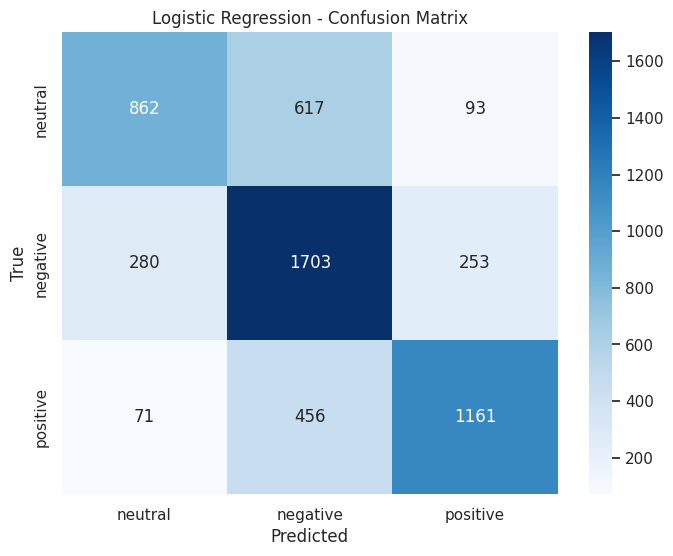

In [20]:
# Generate and plot the confusion matrix for Logistic Regression
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=df['sentiment'].unique(), yticklabels=df['sentiment'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Logistic Regression - Confusion Matrix')
plt.show()

**Logistic Regression Confusion Matrix**

The model correctly classified 862 neutral instances, but misclassified 617 as negative and 93 as positive. For the negative class, it correctly identified 1,703 instances, while misclassifying 280 as neutral and 253 as positive. In the positive class, the model accurately predicted 1,161 instances but misclassified 456 as negative and 71 as neutral.

This indicates that the model is particularly strong at identifying negative sentiments, shown by the high number of correct predictions (1,703) for this class. However, it struggles more with distinguishing neutral and positive sentiments, leading to notable misclassifications between these categories. The overall performance shows a need for improvement in differentiating closely related sentiments, particularly between neutral and negative classes.

In [21]:
print("Logistic Regression - Classification Report:\n", classification_report(y_test, y_pred, target_names=df['sentiment'].unique()))

Logistic Regression - Classification Report:
               precision    recall  f1-score   support

     neutral       0.71      0.55      0.62      1572
    negative       0.61      0.76      0.68      2236
    positive       0.77      0.69      0.73      1688

    accuracy                           0.68      5496
   macro avg       0.70      0.67      0.68      5496
weighted avg       0.69      0.68      0.68      5496



**Logistic Regression Classification Report**

The model's precision, recall, and F1-score for the neutral class are 0.71, 0.55, and 0.62, respectively, indicating that while it is relatively precise in identifying neutral tweets, it misses a significant portion of them, as reflected in the lower recall. For the negative class, the precision is 0.61, recall is 0.76, and F1-score is 0.68, suggesting that the model is more effective in capturing negative tweets, but it also includes more false positives. The positive class shows a precision of 0.77, recall of 0.69, and F1-score of 0.73, demonstrating that the model performs fairly well in identifying positive tweets, although there is still room for improvement.

The model achieves an accuracy of 68%, with the macro average (average of precision, recall, and F1-score for all classes) being 0.70 for precision, 0.67 for recall, and 0.68 for F1-score. The weighted average, which takes into account the support (number of true instances for each class), is slightly lower, indicating that the model's performance is reasonably consistent across different classes but has a slight bias towards the negative class due to its higher support. These metrics suggest that while the model is moderately effective, there is potential for enhancing its precision and recall, particularly for the neutral and positive classes, to improve overall performance.

In [22]:
# Load the pre-trained BERT tokenizer and model
tokenizer= BertTokenizer.from_pretrained('bert-base-uncased')
model= BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3) # 3 sentiment classes

# Encode the text data using the tokenizer
encoded_data= tokenizer.batch_encode_plus(df['text'].tolist(), max_length=128, padding=True, truncation=True, return_tensors='pt')

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
# Split the data into training and test sets for BERT
input_ids= encoded_data['input_ids']
attention_masks= encoded_data['attention_mask']
labels= torch.tensor(df['sentiment'].map({'positive': 0, 'negative': 1, 'neutral': 2}).values)

train_inputs, val_inputs, train_labels, val_labels= train_test_split(input_ids, labels, test_size= 0.2, random_state= 42)
train_masks, val_masks, _, _= train_test_split(attention_masks, input_ids, test_size= 0.2, random_state= 42)

In [24]:
# Convert your data into the required format for the Dataset object
def convert_to_dataset(input_ids, attention_masks, labels):
    dataset = Dataset.from_dict({
        'input_ids': input_ids.numpy(),
        'attention_mask': attention_masks.numpy(),
        'labels': labels.numpy()
    })
    return dataset

In [25]:
# Create the training and validation datasets
train_dataset= convert_to_dataset(train_inputs, train_masks, train_labels)
val_dataset= convert_to_dataset(val_inputs, val_masks, val_labels)

In [30]:
# Use a data collator to handle padding
data_collator= DataCollatorWithPadding(tokenizer)

# Set up the training arguments
training_args= TrainingArguments(output_dir='./bert_output', num_train_epochs=1, per_device_train_batch_size=16, per_device_eval_batch_size=64, warmup_steps=500, weight_decay=0.01, logging_dir='./logs', report_to= 'none')

In [31]:
# Create the trainer
trainer= Trainer(model= model, args= training_args, train_dataset= train_dataset, eval_dataset= val_dataset, data_collator= data_collator, tokenizer= tokenizer)

# Train the model
trainer.train()

Step,Training Loss
500,0.774300
1000,0.585000


TrainOutput(global_step=1374, training_loss=0.6373686478127558, metrics={'train_runtime': 12526.0273, 'train_samples_per_second': 1.755, 'train_steps_per_second': 0.11, 'total_flos': 1242717561106560.0, 'train_loss': 0.6373686478127558, 'epoch': 1.0})

**BERT Model Training Results**

At step 500, the training loss was recorded at 0.7743, indicating the initial stages of the model learning from the data. By step 1000, the training loss had improved significantly to 0.5850, showing that the model was effectively optimizing and reducing errors. The overall average training loss across all steps was 0.6374, reflecting the model's ability to generalize well over the training period.

The training output metrics further highlight the training process. The model underwent a total of 1374 training steps. The total runtime for this training was approximately 12,526 seconds, or about 3.5 hours. The model processed an average of 1.755 samples per second, with a step processing rate of 0.11 steps per second. Additionally, the total floating-point operations (FLOPs) were reported as 1,242,717,561,106,560. These metrics indicate that the training was computationally intensive, but the model achieved a reasonable balance between speed and accuracy, as evidenced by the gradual reduction in training loss.

In [32]:
# Evaluate the BERT model
model.eval()
predictions= []
true_labels= []

In [33]:
# Create a DataLoader for the validation set
val_dataset = TensorDataset(val_inputs, val_masks, val_labels)
val_dataloader = DataLoader(val_dataset, batch_size=32)

In [34]:
# Make predictions on the validation set
with torch.no_grad():
    for batch in val_dataloader:
        batch = tuple(b.to(device) for b in batch)
        inputs = {'input_ids': batch[0], 'attention_mask': batch[1]}
        outputs = model(**inputs)
        logits = outputs[0]
        logits = logits.detach().cpu().numpy()
        label_ids = batch[2].to('cpu').numpy()
        predictions.extend(np.argmax(logits, axis=1))
        true_labels.extend(label_ids)

In [35]:
# Calculate evaluation metrics for BERT
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='weighted')
recall = recall_score(true_labels, predictions, average='weighted')
f1 = f1_score(true_labels, predictions, average='weighted')

print(f'BERT - Accuracy: {accuracy:.2f}')
print(f'BERT - Precision: {precision:.2f}')
print(f'BERT - Recall: {recall:.2f}')
print(f'BERT - F1 Score: {f1:.2f}')

BERT - Accuracy: 0.80
BERT - Precision: 0.80
BERT - Recall: 0.80
BERT - F1 Score: 0.80


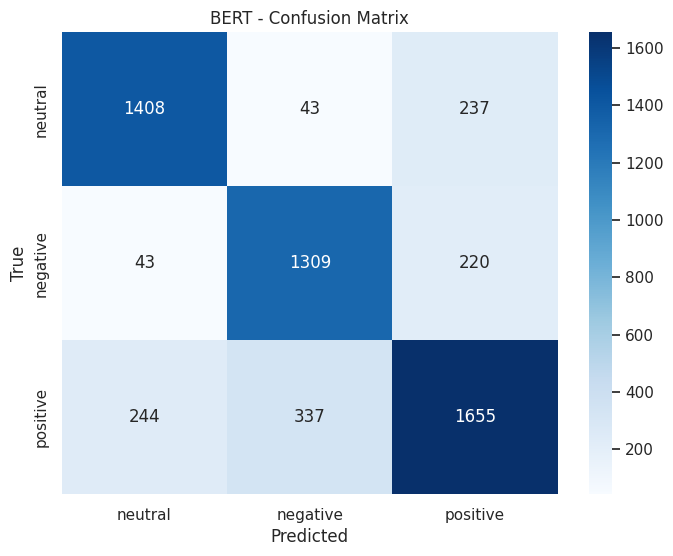

In [36]:
# Generate and plot the confusion matrix for BERT
conf_matrix = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=df['sentiment'].unique(), yticklabels=df['sentiment'].unique())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('BERT - Confusion Matrix')
plt.show()

**BERT Confusion Matrix**

For the neutral class, the model correctly identified 1,408 instances, indicating a strong ability to recognize neutral tweets. However, there were 43 false positives where negative tweets were incorrectly classified as neutral, and 244 false negatives where neutral tweets were misclassified as positive.

For the negative class, the model demonstrated high accuracy with 1,309 true positives. There were 43 false positives where neutral tweets were wrongly identified as negative and 220 false negatives where negative tweets were misclassified as positive. This shows the model's robustness in distinguishing negative sentiment but also highlights areas for improvement in reducing misclassifications.

In the positive class, the model accurately predicted 1,655 instances. However, it showed 337 false positives where negative tweets were classified as positive, and 237 false negatives where neutral tweets were classified as positive. This indicates that while the model performs well in identifying positive sentiment, it sometimes struggles to distinguish it from neutral and negative sentiments.

The confusion matrix reveals that the BERT model has a strong performance in correctly identifying sentiments, particularly neutral and negative. However, there are areas for improvement, especially in reducing the misclassification of neutral and negative tweets as positive. These insights are crucial for fine-tuning the model to enhance its accuracy and reliability further.

In [37]:
# BERT Classification Report
print("BERT - Classification Report:\n", classification_report(true_labels, predictions, target_names=df['sentiment'].unique()))

BERT - Classification Report:
               precision    recall  f1-score   support

     neutral       0.83      0.83      0.83      1688
    negative       0.78      0.83      0.80      1572
    positive       0.78      0.74      0.76      2236

    accuracy                           0.80      5496
   macro avg       0.80      0.80      0.80      5496
weighted avg       0.80      0.80      0.80      5496



**BERT Classification Report**

For the neutral class, the model achieved a precision, recall, and F1-score of 83%, indicating a consistent ability to correctly identify neutral tweets.

In the negative class, the model's precision was 78%, recall was 83%, and F1-score was 80%. This shows that the model is effective at identifying negative sentiment, though there is a slight discrepancy between precision and recall, suggesting it occasionally misclassifies some tweets as negative.

For the positive class, the model had a precision of 78%, recall of 74%, and an F1-score of 76%. These results indicate that while the model performs reasonably well in identifying positive tweets, it has more room for improvement compared to the other classes.

The model achieved an accuracy of 80%, meaning it correctly classified 80% of the tweets. The macro and weighted averages for precision, recall, and F1-score were all 80%, reflecting a balanced performance across all classes. These results suggest that the BERT model is generally effective in sentiment classification but could benefit from further fine-tuning, especially in distinguishing positive sentiments more accurately.

In [40]:
# Tokenization and Vocabulary Creation
def encode_text(texts, vocab=None):
    tokenized_texts = [word_tokenize(text) for text in texts]
    if vocab is None:
        vocab = Counter([token for text in tokenized_texts for token in text])
        vocab = {word: i+1 for i, (word, count) in enumerate(vocab.items())}
    encoded_texts = [[vocab[token] for token in text if token in vocab] for text in tokenized_texts]
    return encoded_texts, vocab

encoded_texts, vocab = encode_text(df['cleaned_text'].values)

In [41]:
# Padding
def pad_sequences(sequences, maxlen):
    padded_sequences = []
    for seq in sequences:
        if len(seq) < maxlen:
            padded_sequences.append([0] * (maxlen - len(seq)) + seq)
        else:
            padded_sequences.append(seq[:maxlen])
    return np.array(padded_sequences)

maxlen = 200
X = pad_sequences(encoded_texts, maxlen=maxlen)

In [42]:
# Encode labels
label_encoder= LabelEncoder()
y= label_encoder.fit_transform(df['sentiment'].values)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
# Create Tensor Datasets
train_data= TensorDataset(torch.tensor(X_train, dtype=torch.long), torch.tensor(y_train, dtype=torch.long))
val_data= TensorDataset(torch.tensor(X_val, dtype=torch.long), torch.tensor(y_val, dtype=torch.long))

# Create Data Loaders
batch_size= 32
train_sampler= RandomSampler(train_data)
train_dataloader= DataLoader(train_data, sampler= train_sampler, batch_size= batch_size)

val_sampler= SequentialSampler(val_data)
val_dataloader= DataLoader(val_data, sampler= val_sampler, batch_size= batch_size)

In [44]:
# Define the LSTM Model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, drop_prob=0.5):
        super(LSTMClassifier, self).__init__()
        self.embedding= nn.Embedding(vocab_size, embedding_dim)
        self.lstm= nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout=drop_prob, batch_first=True)
        self.dropout= nn.Dropout(drop_prob)
        self.fc= nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _= self.lstm(x)
        out= self.dropout(lstm_out[:, -1])
        out= self.fc(out)
        return out

# Model Hyperparameters
vocab_size= len(vocab) + 1
embedding_dim= 100
hidden_dim= 64
output_dim= 3 # Number of classes
n_layers= 1

model= LSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers)

# Training Hyperparameters
epochs= 3
learning_rate= 0.001

# Loss and optimizer
criterion= nn.CrossEntropyLoss()
optimizer= optim.Adam(model.parameters(), lr=learning_rate)

# Early stopping criteria
patience= 3
best_val_loss= np.inf
patience_counter= 0

# Move model to device
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model= model.to(device)

In [49]:
# Training Loop with early stopping criteria
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Early stopping criteria
patience = 3
best_val_loss = np.inf
patience_counter = 0

for epoch in range(epochs):
    model.train()
    train_loss = 0
    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    avg_train_loss = train_loss / len(train_dataloader)
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_dataloader)

    print(f'Epoch {epoch + 1}, Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.2f}')

    # Check early stopping criteria
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0  # Reset counter if validation loss improves
    else:
        patience_counter += 1  # Increment counter if validation loss does not improve

    if patience_counter >= patience:
        print(f'Early stopping at epoch {epoch + 1}')
        break  # This break should be inside the loop

# Save the model
torch.save(model.state_dict(), 'lstm_model.pth')

Epoch 1, Training Loss: 0.5524, Validation Loss: 0.77
Epoch 2, Training Loss: 0.4699, Validation Loss: 0.83
Epoch 3, Training Loss: 0.3962, Validation Loss: 0.87


In [50]:
# Evaluate the model
def evaluate(model, dataloader):
    model.eval()
    preds, true_labels = [], []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, pred = torch.max(outputs, 1)
            preds.extend(pred.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return preds, true_labels

In [51]:
# Get predictions and true labels for training and validation sets
train_preds, train_labels = evaluate(model, train_dataloader)
val_preds, val_labels = evaluate(model, val_dataloader)

In [52]:
# Calculate evaluation metrics for the validation set
accuracy = accuracy_score(val_labels, val_preds)
precision = precision_score(val_labels, val_preds, average='weighted')
recall = recall_score(val_labels, val_preds, average='weighted')
f1 = f1_score(val_labels, val_preds, average='weighted')

# Print evaluation metrics
print(f'Validation Accuracy: {accuracy:.2f}')
print(f'Validation Precision: {precision:.2f}')
print(f'Validation Recall: {recall:.2f}')
print(f'Validation F1 Score: {f1:.2f}')

Validation Accuracy: 0.68
Validation Precision: 0.68
Validation Recall: 0.68
Validation F1 Score: 0.68


In [53]:
# LSTM Classification Report
print("LSTM - Classification Report:\n", classification_report(val_labels, val_preds, target_names=label_encoder.classes_))

LSTM - Classification Report:
               precision    recall  f1-score   support

    negative       0.70      0.59      0.64      1572
     neutral       0.63      0.71      0.67      2236
    positive       0.73      0.72      0.73      1688

    accuracy                           0.68      5496
   macro avg       0.69      0.67      0.68      5496
weighted avg       0.68      0.68      0.68      5496



**LSTM Classification Report**

For the negative class, the model achieved a precision of 70%, a recall of 59%, and an F1-score of 64%. This suggests that the model can identify negative tweets fairly well but has a moderate level of false negatives. For the neutral class, the model achieved a precision of 63%, a recall of 71%, and an F1-score of 67%. These metrics indicate that the model is relatively good at identifying neutral tweets, although there is room for improvement in precision. The positive class shows a precision of 73%, a recall of 72%, and an F1-score of 73%, reflecting a balanced performance in recognizing positive tweets. The overall accuracy of the model is 68%, with macro and weighted averages for precision, recall, and F1-score around 68-69%. These results suggest that while the LSTM model performs reasonably well, there is variability in its effectiveness across different classes.

**Comparison of All Models**

When comparing the performance of the Logistic Regression, BERT, and LSTM models, several key differences emerge. The logistic regression model achieved an accuracy of 68% with consistent precision, recall, and F1-scores around 68-69%. It showed moderate performance but struggled to distinguish between the different sentiment classes effectively. The BERT model, on the other hand, outperformed the logistic regression and LSTM models, achieving an accuracy of 80%. It had higher precision and recall for all classes, especially for neutral and negative sentiments, indicating its strong capability in sentiment analysis tasks. The LSTM model also performed well with an accuracy of 68%, similar to the logistic regression model, but showed better balance in precision and recall across the different sentiment classes compared to logistic regression.

**Conclusion**

Among the three models evaluated, the BERT model demonstrated the best overall performance with an accuracy of 80% and strong precision, recall, and F1-scores across all sentiment classes. It effectively distinguished between negative, neutral, and positive sentiments, making it the most reliable choice for sentiment analysis of Twitter tweets. While the logistic regression and LSTM models provided useful baselines, the BERT model's advanced capabilities in understanding contextual nuances and capturing the complexities of language make it the superior choice. This notebook successfully developed and evaluated multiple machine learning models for sentiment analysis, providing valuable insights into public sentiment expressed in tweets and highlighting the effectiveness of BERT in such tasks.